In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
# Download Oxford 17 Category Flower Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz
!tar -xvzf 17flowers.tgz

--2022-11-16 08:03:11--  http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz [following]
--2022-11-16 08:03:11--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  11.0MB/s    in 6.7s    

2022-11-16 08:03:19 (8.59 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]

jpg/files.txt
jpg/files.txt~
jpg/image_0001.jpg
jpg/image_0002.jpg
jpg/image_0003.jpg
jpg/image_0004.jpg
jpg/image_0005.jpg
jpg/image_0006.jpg
jpg/image_0007.jpg

In [13]:
# Split the images in ./jpg into 17 folders
!cd ./jpg && for i in {1..17}; do mkdir $i; done
# Move image_xxxx.jpg to folder (((xxxx-1)//80) + 1)
!cd ./jpg && for i in {1..1360}; do mv image_$(printf "%04d" $i).jpg $(($((i-1))/80 + 1)); done

mkdir: cannot create directory ‘1’: File exists
mkdir: cannot create directory ‘2’: File exists
mkdir: cannot create directory ‘3’: File exists
mkdir: cannot create directory ‘4’: File exists
mkdir: cannot create directory ‘5’: File exists
mkdir: cannot create directory ‘6’: File exists
mkdir: cannot create directory ‘7’: File exists
mkdir: cannot create directory ‘8’: File exists
mkdir: cannot create directory ‘9’: File exists
mkdir: cannot create directory ‘10’: File exists
mkdir: cannot create directory ‘11’: File exists
mkdir: cannot create directory ‘12’: File exists
mkdir: cannot create directory ‘13’: File exists
mkdir: cannot create directory ‘14’: File exists
mkdir: cannot create directory ‘15’: File exists
mkdir: cannot create directory ‘16’: File exists
mkdir: cannot create directory ‘17’: File exists


In [14]:
# Build the ResNet50 model with or without pretrained weights
# Change all Relu functions to LeakyRelu
def get_model(pretrain):
    if pretrain == 1:
        model = torchvision.models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
    else:
        model = torchvision.models.resnet50(weights=None)
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            model._modules[name] = nn.LeakyReLU(inplace=True)
    model.classifier = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.LeakyReLU(inplace=True),
        nn.Linear(1024, 17),
    )
    return model

In [15]:
# Build the transformer for the dataset in training, validation and testing
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Build the dataset in training, validation and testing from ./jpg where the images are stored in 17 folders
train_dataset = torchvision.datasets.ImageFolder(root='./jpg', transform=transformer)

# Split the dataset into training, validation and testing
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

In [16]:
# Set the batch size used for model training
batch_sizes =[4, 32, 64]

In [17]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [18]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs, test_loader):
    train_loss = []
    valid_loss = []
    test_acc = []
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        valid_loss.append(validate(model, device, valid_loader))
        test_acc.append(test(model, device, test_loader))
    return train_loss, valid_loss, test_acc


In [19]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Batch size: 4
Train Epoch: 1 [0/1088 (0%)]	Loss: 9.640459
Train Epoch: 1 [400/1088 (37%)]	Loss: 0.554291
Train Epoch: 1 [800/1088 (74%)]	Loss: 0.450459
Validation set: Average loss: 0.3766, Accuracy: 124/136 (91%)
Test set: Average loss: 0.4011, Accuracy: 119/136 (88%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 0.590333
Train Epoch: 2 [400/1088 (37%)]	Loss: 0.238111
Train Epoch: 2 [800/1088 (74%)]	Loss: 0.644249
Validation set: Average loss: 0.3302, Accuracy: 122/136 (90%)
Test set: Average loss: 0.2472, Accuracy: 127/136 (93%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 0.079225
Train Epoch: 3 [400/1088 (37%)]	Loss: 0.157489
Train Epoch: 3 [800/1088 (74%)]	Loss: 1.136817
Validation set: Average loss: 0.2844, Accuracy: 131/136 (96%)
Test set: Average loss: 0.3340, Accuracy: 126/136 (93%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 0.001246
Train Epoch: 4 [400/1088 (37%)]	Loss: 0.767826
Train Epoch: 4 [800/1088 (74%)]	Loss: 0.035813
Validation set: Average loss: 0.1537, Accuracy: 130/136 (96%)
Test set: Average 

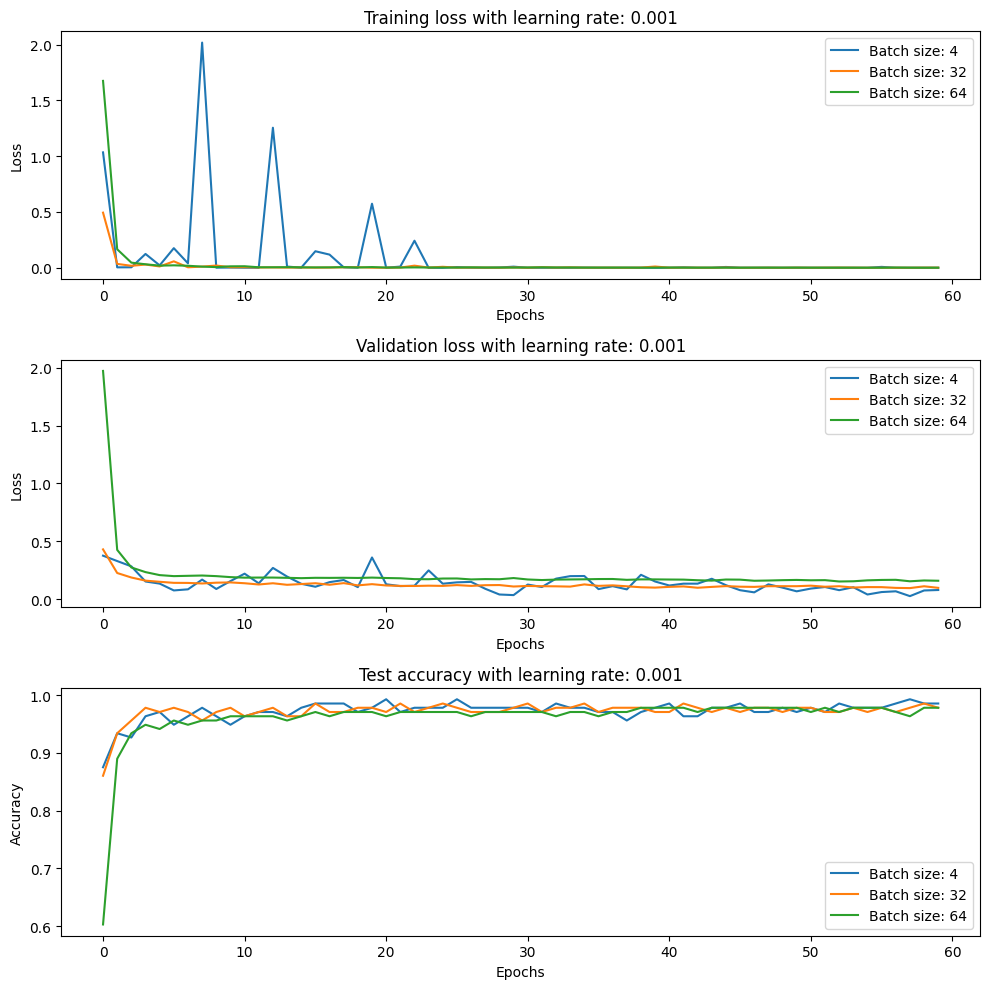

In [20]:
# Empty the GPU memory
torch.cuda.empty_cache()

# Start training and testing
# With different batch sizes and learning rates

# Set subplots for plotting with 9 rows and 1 column each subplot with size 10*6
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
learnR = 0.001
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = get_model(1)
    model = model.to(device)
    optimizer = get_optimizer(model, learnR)
    train_loss, valid_loss, test_acc = train_process(model, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

    # Plot the training for different batch sizes
for i in range(len(batch_sizes)):
    axs[0].plot(train_losses[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[0].set_title('Training loss with learning rate: {}'.format(learnR))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the validation for different batch sizes
for i in range(len(batch_sizes)):
    axs[1].plot(valid_losses[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[1].set_title('Validation loss with learning rate: {}'.format(learnR))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
        

# Plot the test accuracy for different batch sizes
for i in range(len(batch_sizes)):
    axs[2].plot(test_accs[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[2].set_title('Test accuracy with learning rate: {}'.format(learnR))
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./train_loss' + str(learnR) + '.csv', index=False)
valid_lossespd.to_csv('./valid_loss' + str(learnR) + '.csv', index=False)
test_accspd.to_csv('./test_acc' + str(learnR) + '.csv', index=False)

plt.tight_layout()
plt.show()

Batch size: 4
Train Epoch: 1 [0/1088 (0%)]	Loss: 7.065778
Train Epoch: 1 [400/1088 (37%)]	Loss: 3.067274
Train Epoch: 1 [800/1088 (74%)]	Loss: 3.842535
Validation set: Average loss: 4.2031, Accuracy: 18/136 (13%)
Test set: Average loss: 4.4500, Accuracy: 19/136 (14%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 4.242281
Train Epoch: 2 [400/1088 (37%)]	Loss: 2.237739
Train Epoch: 2 [800/1088 (74%)]	Loss: 3.217100
Validation set: Average loss: 4.2629, Accuracy: 29/136 (21%)
Test set: Average loss: 4.1882, Accuracy: 24/136 (18%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 3.947232
Train Epoch: 3 [400/1088 (37%)]	Loss: 2.800148
Train Epoch: 3 [800/1088 (74%)]	Loss: 2.770442
Validation set: Average loss: 3.1570, Accuracy: 21/136 (15%)
Test set: Average loss: 3.3669, Accuracy: 25/136 (18%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 3.686693
Train Epoch: 4 [400/1088 (37%)]	Loss: 3.135810
Train Epoch: 4 [800/1088 (74%)]	Loss: 1.912279
Validation set: Average loss: 3.8371, Accuracy: 28/136 (21%)
Test set: Average loss: 4

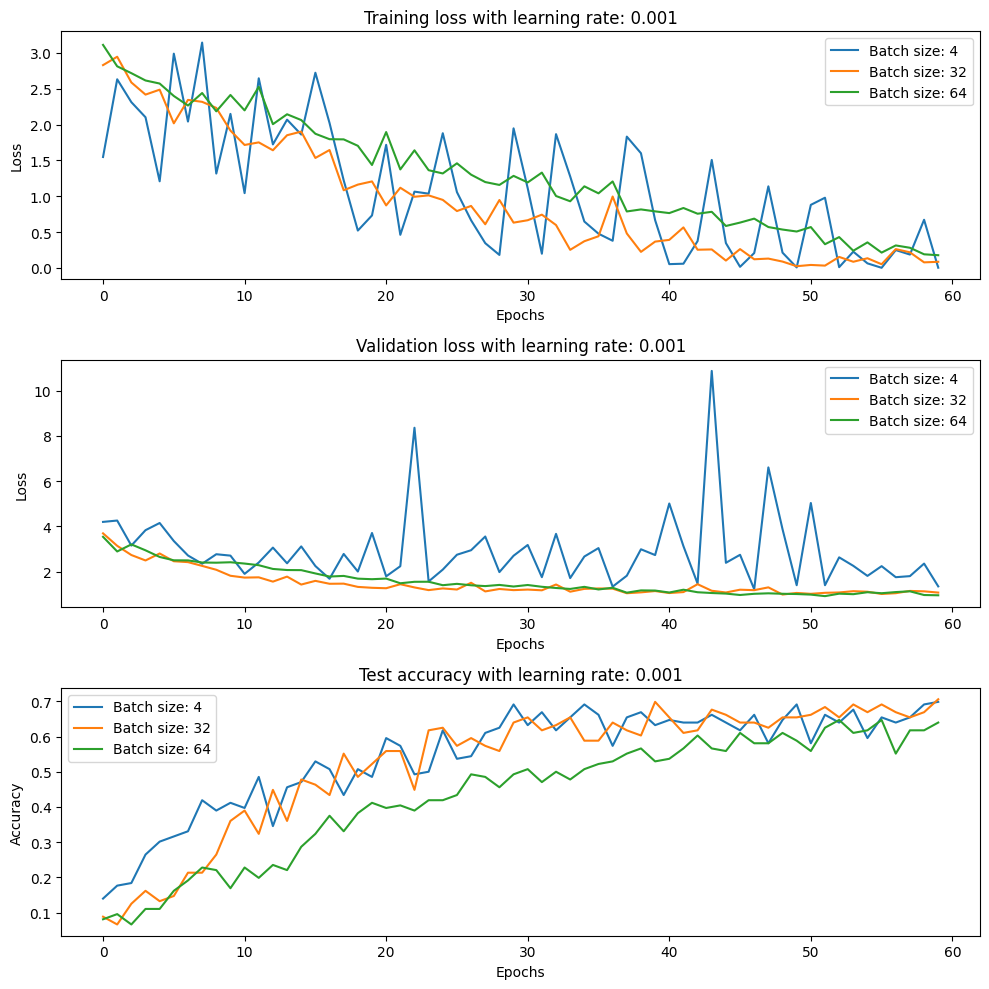

In [21]:
# Empty the GPU memory
torch.cuda.empty_cache()

# Start training and testing
# With different batch sizes and learning rates

# Set subplots for plotting with 9 rows and 1 column each subplot with size 10*6
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
learnR = 0.001
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = get_model(0)
    model = model.to(device)
    optimizer = get_optimizer(model, learnR)
    train_loss, valid_loss, test_acc = train_process(model, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

    # Plot the training for different batch sizes
for i in range(len(batch_sizes)):
    axs[0].plot(train_losses[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[0].set_title('Training loss with learning rate: {}'.format(learnR))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot the validation for different batch sizes
for i in range(len(batch_sizes)):
    axs[1].plot(valid_losses[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[1].set_title('Validation loss with learning rate: {}'.format(learnR))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
        

# Plot the test accuracy for different batch sizes
for i in range(len(batch_sizes)):
    axs[2].plot(test_accs[i], label='Batch size: {}'.format(batch_sizes[i]))
axs[2].set_title('Test accuracy with learning rate: {}'.format(learnR))
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./train_loss_np' + str(learnR) + '.csv', index=False)
valid_lossespd.to_csv('./valid_loss_np' + str(learnR) + '.csv', index=False)
test_accspd.to_csv('./test_acc_np' + str(learnR) + '.csv', index=False)

plt.tight_layout()
plt.show()